In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"

import jax.numpy as np
import matplotlib.pyplot as plt
from jax import random
from nrmifactors import algorithm as algo
from nrmifactors.state import State
import nrmifactors.priors as priors

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [2]:
ndata = 500

key = random.PRNGKey(0)

means = np.array([-10.0, -3.0, 3.0, 10.0])

probas = np.vstack(
    [np.ones(4),
     np.array([0, 1, 0, 1]),
     np.array([1, 0, 1, 0]),
     np.array([0, 0, 1, 1]),
     np.array([1, 1, 0, 0]),
     np.array([0, 0.2, 0, 0.8]),
     np.array([0.7, 0.3, 0, 0])]
)

probas = np.vstack(
    [np.ones(4),
     np.array([0.0, 1.0, 0.0, 1.0]),
     np.array([1.0, 0.0, 1.0, 0.0]),
     np.array([0.0, 0.2, 0.0, 0.8]),
     np.array([0.7, 0.0, 0.3, 0.0]),
     np.array([1.0, 0.0, 0.0, 0.0])
    ]
)

ngroups = probas.shape[0]

probas = probas / probas.sum(axis=1)[:, np.newaxis]

key, subkey = random.split(key)
clus = tfd.Categorical(probs=probas).sample((ndata), seed=subkey).T
data = tfd.Normal(means[clus], np.ones_like(clus, dtype=float)).sample(seed=subkey)

In [3]:
probas

DeviceArray([[0.25, 0.25, 0.25, 0.25],
             [0.  , 0.5 , 0.  , 0.5 ],
             [0.5 , 0.  , 0.5 , 0.  ],
             [0.  , 0.2 , 0.  , 0.8 ],
             [0.7 , 0.  , 0.3 , 0.  ],
             [1.  , 0.  , 0.  , 0.  ]], dtype=float64)

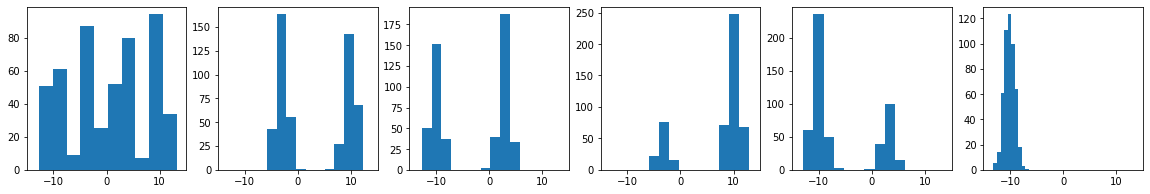

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=ngroups, figsize=(20, 3))
for i in range(ngroups):
    axes[i].hist(data[i, :])
    axes[i].set_xlim(-15, 15)

In [5]:
natoms = 10
nlat = 4

# initialize stuff
init_atoms = np.hstack([
    tfd.Normal(loc=0, scale=10).sample(natoms, seed=key).reshape(-1, 1),
    np.ones((natoms, 1)) * 3
])

# init_atoms = np.hstack([means.reshape(-1, 1), np.ones_like(means).reshape(-1, 1) * 1])

prior = priors.NrmiFacPrior(
    kern_prior=priors.NNIGPrior(0.0, 0.001, 3.0, 3.0),
    lam_prior=priors.GammaPrior(2.0, 1.0),
    m_prior=priors.GammaPrior(2.0, 1.0),
    j_prior=priors.GammaPrior(1.0, 1.0))


lam = tfd.Gamma(prior.lam_prior.a, prior.lam_prior.b).sample((ngroups, nlat), seed=key).astype(float)
#m = np.hstack([np.eye(nlat) * 5 + 0.5, np.zeros((nlat, natoms - nlat)) + 0.5])
m = tfd.Gamma(prior.m_prior.a, prior.m_prior.b).sample((nlat, natoms), seed=key).astype(float)



j = np.ones(natoms).astype(float) * 0.5
u = np.ones(ngroups).astype(float)

clus = tfd.Categorical(probs=np.ones(natoms)/natoms).sample(data.shape, seed=key)
state = State(init_atoms, j, lam, m, clus, u)

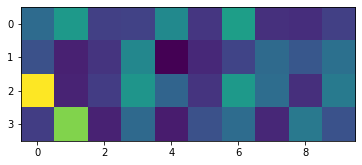

In [6]:
plt.imshow(state.m)

In [7]:
from copy import deepcopy

niter = 10000
nburn = 5000
thin = 1

states = [deepcopy(state)]
for i in range(niter):
    print("\r{0}/{1}".format(i+1, niter), flush=True, end=" ")
    state, key = algo.run_one_step(state, data, prior, key)
    if (i > nburn) and (i % thin == 0):
        states.append(deepcopy(state))

10000/10000             

In [9]:
import pickle


with open("simulation1_chains.pickle", "wb") as fp:
    pickle.dump(states, fp)

In [10]:
def eval_densities(xgrid, lam, m, j, atoms):
    weights = np.matmul(lam, m) * state.j
    weights /= weights.sum(axis=1)[:, np.newaxis]
    eval_comps = tfd.Normal(loc=atoms[:, 0], scale=np.sqrt(atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens = eval_comps[:, np.newaxis, :] * weights[np.newaxis, :, :]
    dens = np.sum(dens, axis=-1).T
    return dens

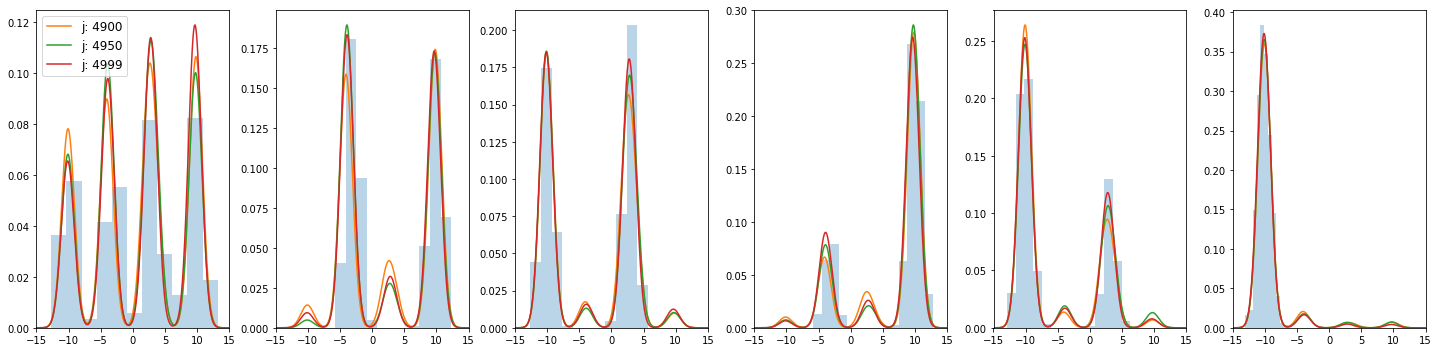

In [11]:
xgrid = np.linspace(-15, 15, 1000)

fig, axes = plt.subplots(nrows=1, ncols=ngroups, figsize=(20, 5))

idx = [-1, -100, -50]

for i in range(ngroups):
    axes[i].hist(data[i, :], density=True, alpha=0.3, bins="doane")

for j in sorted(idx):

    state = states[j]
    dens = eval_densities(xgrid, state.lam, state.m, state.j, state.atoms)
    for i in range(ngroups):
        axes[i].plot(xgrid, dens[i, :], label="j: {0}".format(len(states) + j))
        axes[i].set_xlim(-15, 15)
        
axes[0].legend(fontsize=12)   
plt.tight_layout()
# plt.savefig("simu1/dens_estimate.pdf", bbox_inches="tight")        
plt.show()

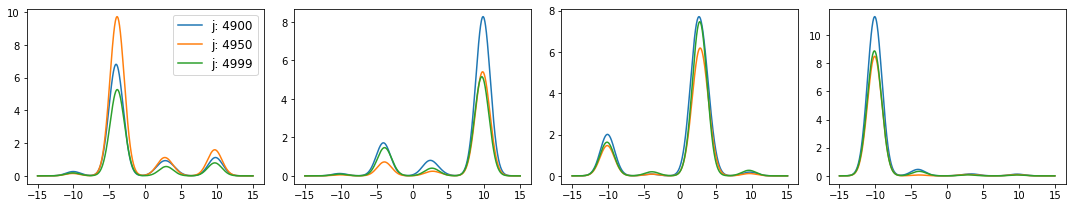

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=nlat, figsize=(15, 3))

for j in sorted(idx):
    state = states[j]

    eval_comps = tfd.Normal(
        loc=state.atoms[:, 0], scale=np.sqrt(state.atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens_lat = eval_comps[:, np.newaxis, :] * (state.m * state.j)[np.newaxis, :, :]
    dens_lat = np.sum(dens_lat, axis=-1).T    


    for i in range(nlat):
        axes[i].plot(xgrid, dens_lat[i, :], label="j: {0}".format(len(states) + j))
        
axes[0].legend(fontsize=12)

plt.tight_layout()

# plt.savefig("simu1/latent_dens.pdf", bbox_inches="tight")        
plt.show()

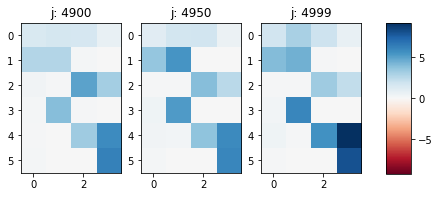

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=len(idx), figsize=(7, 3))

idx = sorted(idx)

lambs = np.array([states[i].lam for i in idx])
vmax = np.max(lambs)

for i in range(len(idx)):
    lam = states[idx[i]].lam
    im = axes[i].imshow(lam, vmax=vmax, vmin=-vmax, cmap="RdBu")
    axes[i].set_title("j: {0}".format(len(states) + idx[i]))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)    

# plt.savefig("simu1/lambdas.pdf", bbox_inches="tight")

plt.show()

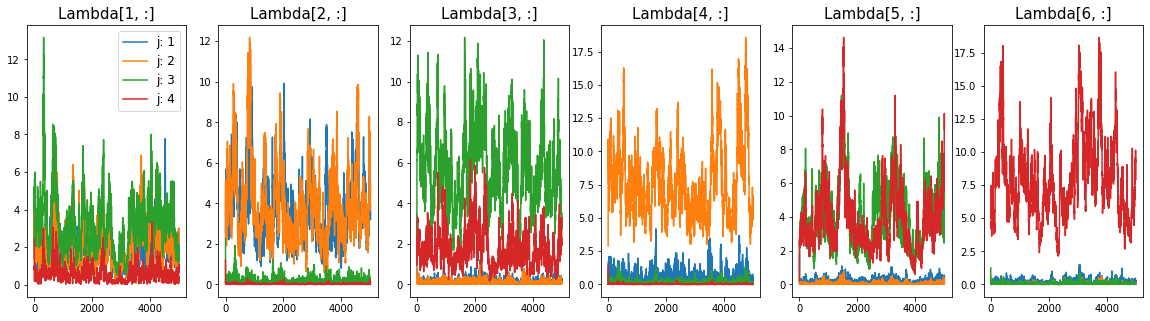

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=ngroups, figsize=(20, 5))

for i in range(ngroups):
    for j in range(nlat):
        axes[i].plot([x.lam[i, j] for x in states], label="j: {0}".format(j + 1))
    
    axes[i].set_title("Lambda[{0}, :]".format(i+1), fontsize=15)

axes[0].legend(fontsize=12)

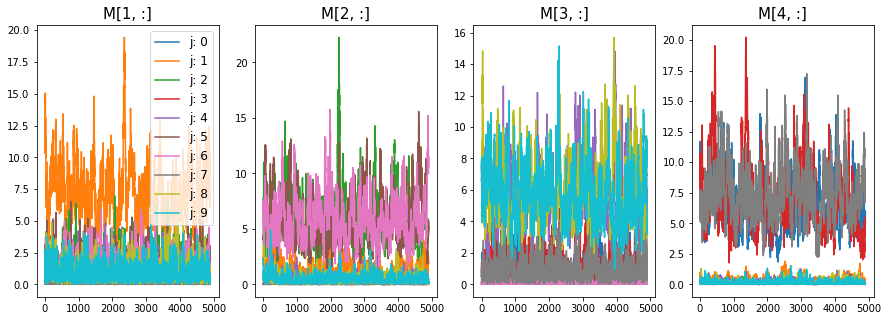

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=nlat, figsize=(15, 5))

for i in range(nlat):
    for j in range(natoms):
        axes[i].plot([x.m[i, j] for x in states[100:]], label="j: {0}".format(j))
    axes[i].set_title("M[{0}, :]".format(i+1), fontsize=15)

axes[0].legend(fontsize=12)

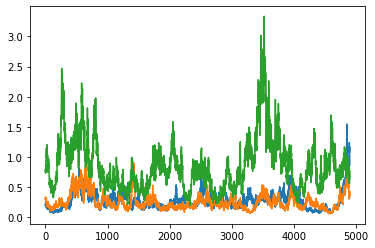

In [65]:
for j in range(3):
    plt.plot([x.j[j] for x in states[100:]], label="j: {0}".format(1))

# Orthogonalization of the \mu^*

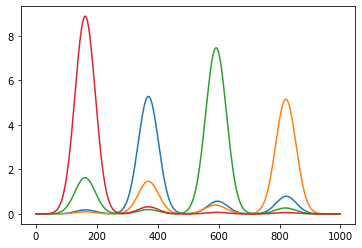

In [16]:
for i in range(4):
    plt.plot(dens_lat[i, :])

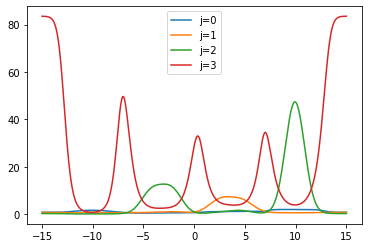

In [167]:
dens_lat_log = np.log(dens_lat + 1e-1)
xxt = (dens_lat_log @ dens_lat_log.T) * (xgrid[1]-xgrid[0])

eigvals, eigvecs = np.linalg.eigh(xxt)

for i in range(4):
    plt.plot(xgrid, np.exp((eigvecs.T @ dens_lat_log)[i, :]), label="j={0}".format(i))
    
plt.legend()

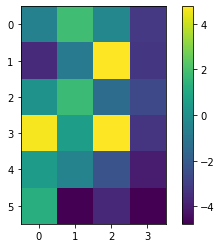

In [170]:
newlam = state.lam @ eigvecs
plt.imshow(newlam, vmax=np.max(newlam), vmin=-np.max(newlam))
plt.colorbar()

In [171]:
newlam

DeviceArray([[-0.56947227,  1.8316681 , -0.37158213, -3.19991878],
             [-3.61472585, -0.83670379,  4.74190875, -3.26809222],
             [ 0.11962768,  1.74680707, -1.3873421 , -2.67805362],
             [ 4.64321284,  0.57332115,  4.76933732, -3.28479086],
             [ 0.51551767, -0.49507858, -2.31759276, -4.00507076],
             [ 1.26135672, -4.95632104, -3.67350081, -5.73158045]],            dtype=float64)

In [139]:
np.cumsum(np.arange(3))

DeviceArray([0, 1, 3], dtype=int64)

In [142]:
np.cumsum(eigvals / np.sum(eigvals))

DeviceArray([0.00280893, 0.03810731, 0.17102642, 1.        ], dtype=float64)

# Orthogonalization via Wasserstein PCA

In [66]:
from pynverse import inversefunc

In [103]:
from scipy.stats import norm
from scipy.interpolate import PchipInterpolator
from jax.ops import index, index_update

def mixture_quantile(m, j, thetas, qrange=np.linspace(0, 1, 500)):
    ranges = np.vstack([[x[0] - 5 * x[1], x[0] + 5 * x[1]] for x in thetas])
    xmin = np.min(ranges)
    xmax = np.max(ranges)
    
    cdf_grid = np.linspace(xmin, xmax, 1000)
    cdfs = np.zeros((m.shape[0], len(cdf_grid)))
    for i in range(thetas.shape[0]):
        cdfs += (norm.cdf(cdf_grid, thetas[i, 0], thetas[i, 1]).reshape(-1, 1) * m[:, i]  * j[i]).T
        
    cdfs /= np.max(cdfs, axis=1)[:, np.newaxis]
    
    quants = np.zeros((m.shape[0], len(qrange)))
    for i in range(m.shape[0]):
        keep = np.where(np.diff(cdfs[i, :]) > 1e-6)[0]
        interp = PchipInterpolator(cdfs[i, :][keep], cdf_grid[keep])
        quants = index_update(quants, index[i, :], interp(qrange))
    return quants

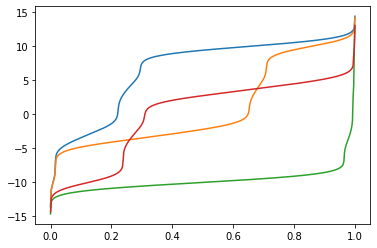

In [118]:
quants = mixture_quantile(state.m, state.j, state.atoms)
for i in range(4):
    plt.plot(np.linspace(0, 1, 500), quants[i, :])

In [109]:
xxt = np.matmul(quants, quants.T)
eigvals, eigvecs = np.linalg.eigh(xxt)

In [119]:
eigvecs

DeviceArray([[-0.61461978,  0.33260441,  0.25023869, -0.6700727 ],
             [ 0.01254308, -0.82255369,  0.52223284, -0.22476866],
             [-0.40787852,  0.17790383,  0.58269543,  0.68003777],
             [ 0.67507059,  0.42559365,  0.57019251, -0.19501345]],            dtype=float64)

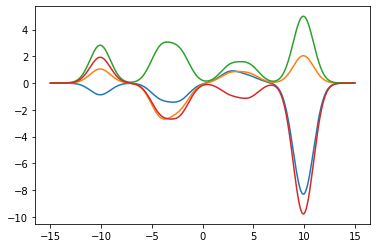

In [122]:
for i in range(4):
    plt.plot(xgrid, (eigvecs.T @ dens_lat)[i, :])

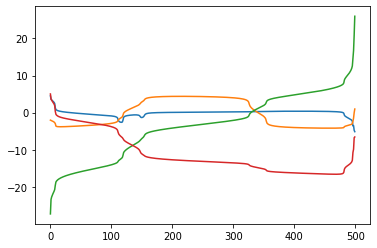

In [121]:
for i in range(4):
    plt.plot((eigvecs.T @ quants)[i, :])

In [120]:
trans_quants = eigvecs.T @ quants
np.dot(trans_quants[1, :], trans_quants[2, :])

DeviceArray(-5.37284335e-12, dtype=float64)

# Orthogonalization via constrained minimization